In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.io import loadmat

from neurodsp.spectral import compute_spectrum
from fooof import FOOOF

from timescales.fit import convert_knee_val, fit_psd
from timescales.sim import sim_spikes_synaptic
from timescales.autoreg import compute_ar_spectrum
from timescales.plts import plot_connected_scatter
from timescales.utils import create_windows

from tqdm.notebook import tqdm

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
LARGE_SIZE = 24

plt.rc('lines', linewidth=2)

plt.rc('font', size=SMALL_SIZE, family='sans-serif')
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=LARGE_SIZE)

plt.rc('ytick.major', size=5)
plt.rc('ytick.minor', size=2.5)
plt.rc('xtick.major', size=5)
plt.rc('xtick.minor', size=2.5)

sns.set_palette('colorblind')

### Modified Lorentzian

This notebook adds a modified Lorentzian, specifically the addition of a constant, that allows tapering to a constant power at high frequencies. This is commonly found in spike trains (real and simulated) and in autoregressive estimates of PSD.

This removes the guess work when deciding on a spike bin size. Before, binning or narrowing in on a frequency range was required to ignore the tapered tail of the PSD.

In [3]:
np.random.seed(0)
n_seconds = 20
fs = 10000
tau = convert_knee_val(10)

_, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1)

In [4]:
f_range = (0, 100)
fooof_init = {'aperiodic_mode': 'knee_constant', 'max_n_peaks': 0}

freqs_welch, powers_welch = compute_spectrum(spikes.reshape(-1, 10).sum(axis=1), fs/10)
freqs_ar, powers_ar = compute_ar_spectrum(spikes.reshape(-1, 10).sum(axis=1), fs/10, order=10)

_, knee_freq_welch = fit_psd(freqs_welch, powers_welch, f_range, knee_bounds=f_range, fooof_init=fooof_init)
_, knee_freq_ar = fit_psd(freqs_ar, powers_ar, f_range, knee_bounds=f_range, fooof_init=fooof_init)

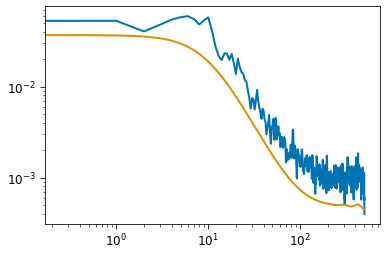

In [5]:
plt.loglog(freqs_welch, powers_welch)
plt.loglog(freqs_ar, powers_ar)

In [6]:
print('Knee Freq True : ', 10)
print('Knee Freq Welch: ', knee_freq_welch)
print('Knee Freq AR   : ', knee_freq_ar)

Knee Freq True :  10
Knee Freq Welch:  13.549621147742052
Knee Freq AR   :  10.234217600084438


### Real Data

The spiking data below is from the sleep-wake fcx1 dataset on crcns. The authors of the dataset provided putative inhibitory/excitatory spike times.

In [7]:
# Load data
dir_path = '/home/rph/Projects/timescale-methods/fcx1/20140526_277um'
subtype_dict = loadmat(f'{dir_path}/20140526_277um_SSubtypes.mat')

fs = 20000
n_seconds = 14000
times = np.arange(0, n_seconds, 1/fs)

# Extract behavioral data
beh_file = f'{dir_path}/20140526_277um_WSRestrictedIntervals.mat'

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

# Window by trial type
win_len = int(10*fs)
win_spacing = int(10*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake = np.vstack((wake_starts, wake_ends)).T
start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T

In [8]:
knees = {
    'inhib':
         {'wake': {'welch': None, 'ar': None},
          'nrem': {'welch': None, 'ar': None}},
    'excite':
        {'wake': {'welch': None, 'ar': None},
         'nrem': {'welch': None, 'ar': None}}
}

powers = deepcopy(knees)

rsq = deepcopy(knees)

In [9]:
order = 5
bin_size = 50

subtype_e = subtype_dict['Se_CellFormat'][0]
subtype_i = subtype_dict['Si_CellFormat'][0]

# Take sum across EI units
spikes_e = np.zeros(int(n_seconds * fs))
for s in subtype_e:
    spikes_e[(s[:, 0] * fs).astype(int)] = 1
         
spikes_i = np.zeros(int(n_seconds * fs))
for s in subtype_i:
    spikes_i[(s[:, 0] * fs).astype(int)] = 1

# Compute spectra
f_range = (0, 100)

fooof_init = {
    'max_n_peaks': 4,
    'peak_threshold': 3,
    'aperiodic_mode': 'knee_constant'
}

kwargs = dict(fooof_init=fooof_init, knee_bounds=f_range)
trials = ['wake', 'nrem']

for tind, start_end in enumerate([start_end_wake, start_end_nrem]):
    
    # Excitatory
    powers_ar_e = np.zeros((len(start_end), 4096//2))
    
    for ind, (s, e) in tqdm(enumerate(start_end), total=len(start_end)):
        spikes_bin = spikes_e[s:e].reshape(-1, bin_size).sum(axis=1)

        freqs_ar, p = compute_ar_spectrum(spikes_bin, fs/bin_size, order)
        powers_ar_e[ind] = p

    fm_ar_e, knees_ar_e = fit_psd(freqs_ar, powers_ar_e, f_range, **kwargs)
            
    powers['excite'][trials[tind]]['ar'] = powers_ar_e
    knees['excite'][trials[tind]]['ar'] = knees_ar_e
    rsq['excite'][trials[tind]]['ar'] = fm_ar_e.get_params('r_squared')
    
    # Inhibitory
    powers_ar_i = np.zeros((len(start_end), 4096//2))
    rsq_welch_i = np.zeros((len(start_end)))
    
    for ind, (s, e) in tqdm(enumerate(start_end), total=len(start_end)):
        spikes_bin = spikes_i[s:e].reshape(-1, bin_size).sum(axis=1)

        freqs_ar, p = compute_ar_spectrum(spikes_bin, fs/bin_size, order)
        powers_ar_i[ind] = p

    fm_ar_i, knees_ar_i = fit_psd(freqs_ar, powers_ar_i, f_range, **kwargs)
    
    powers['inhib'][trials[tind]]['ar'] = powers_ar_i
    knees['inhib'][trials[tind]]['ar'] = knees_ar_i
    rsq['inhib'][trials[tind]]['ar'] = fm_ar_i.get_params('r_squared')

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

Text(0.5, 1.0, 'R-Squared')

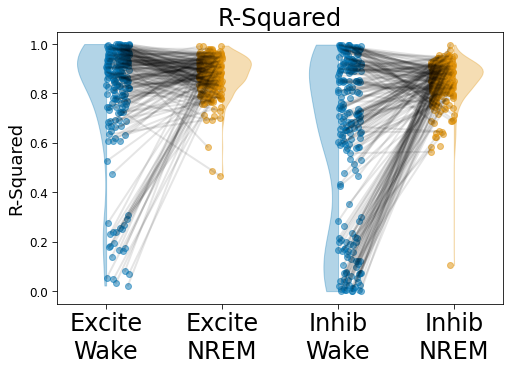

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

ri_wake = rsq['inhib']['wake']['ar']
ri_nrem = rsq['inhib']['nrem']['ar']
re_wake = rsq['excite']['wake']['ar']
re_nrem = rsq['excite']['nrem']['ar']

plot_connected_scatter(re_wake, re_nrem, ax=ax)

plot_connected_scatter(ri_wake, ri_nrem, ax=ax, violin_locs=(3, 4),
                       scatter_a_loc=(3, 3.2), scatter_b_loc=(3.8, 4), xticks=[3, 4])

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Excite\nWake', 'Excite\nNREM', 'Inhib\nWake', 'Inhib\nNREM'])
ax.set_ylabel('R-Squared')
ax.set_title('R-Squared')

Text(0.5, 1.0, 'Timescales')

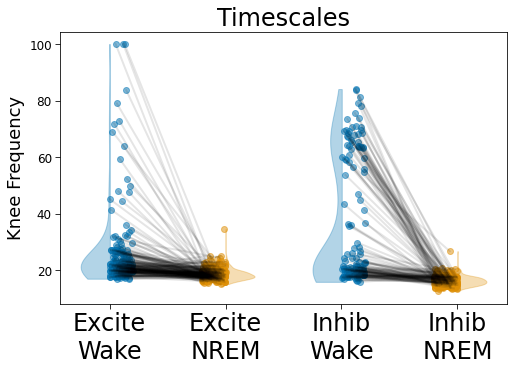

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))


ki_wake = knees['inhib']['wake']['ar'][np.where(ri_wake >= .6)[0]]
ki_nrem = knees['inhib']['nrem']['ar'][np.where(ri_nrem >= .6)[0]]
ke_wake = knees['excite']['wake']['ar'][np.where(re_wake >= .6)[0]]
ke_nrem = knees['excite']['nrem']['ar'][np.where(re_nrem >= .6)[0]]

plot_connected_scatter(ke_wake, ke_nrem, ax=ax)

plot_connected_scatter(ki_wake, ki_nrem, ax=ax, violin_locs=(3, 4),
                       scatter_a_loc=(3, 3.2), scatter_b_loc=(3.8, 4), xticks=[3, 4])

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Excite\nWake', 'Excite\nNREM', 'Inhib\nWake', 'Inhib\nNREM'])
ax.set_ylabel('Knee Frequency')
ax.set_title('Timescales')

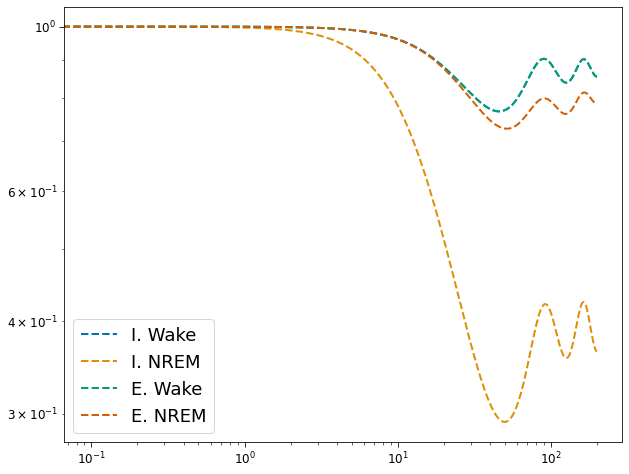

In [12]:
plt.figure(figsize=(10, 8))

powers_inhib_wake = powers['inhib']['wake']['ar'].mean(axis=0)
powers_inhib_wake /= powers_inhib_wake[1]

powers_inhib_nrem = powers['inhib']['nrem']['ar'].mean(axis=0)
powers_inhib_nrem /= powers_inhib_nrem[1]

powers_excite_wake = powers['excite']['wake']['ar'].mean(axis=0)
powers_excite_wake /= powers_excite_wake[1]

powers_excite_nrem = powers['excite']['nrem']['ar'].mean(axis=0)
powers_excite_nrem /= powers_excite_nrem[1]

plt.loglog(freqs_ar, powers_inhib_wake, ls='--', label='I. Wake')
plt.loglog(freqs_ar, powers_inhib_nrem, ls='--', label='I. NREM')
plt.loglog(freqs_ar, powers_inhib_wake, ls='--', label='E. Wake')
plt.loglog(freqs_ar, powers_excite_wake, ls='--', label='E. NREM')

#plt.axvline(ki_wake.mean(), color='C0')
#plt.axvline(ki_nrem.mean(), color='C1')
#plt.axvline(ke_wake.mean(), color='C2')
#plt.axvline(ke_nrem.mean(), color='C3')

plt.legend();